In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# まず最初にやること
分析設計（目的変数・説明変数・バリデーション・評価指標の決定）

### データの確認
- 欠損値はどれだけあるか
  - 一番初めは、欠損値の処理は行わないようにする
  - 後々の特徴量エンジニアリングで非常に重要な要素である可能性があるため
- データのカラム数・レコード数はいくつあるか

In [2]:
df_titanic_train = pd.read_csv("../data/train.csv")

print(df_titanic_train.head())
print(df_titanic_train.info())
print(df_titanic_train.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

### 目的変数と説明変数の作成
- 最初は必要最低限でいい
- 今回は「Sex」と「Fare」をベースライン作成に用いる説明変数とする
  - 欠損値がなく、感覚的に目的変数との関わりが深そうだから
- また、「Sex」はダミー変数に変換
  - 0：女性
  - 1：男性

In [3]:
le = LabelEncoder()
df_titanic_train["Sex"] = le.fit_transform(df_titanic_train["Sex"])

# ベースライン検証データに分割
df_titanic_train, df_titanic_train_baseline = train_test_split(
    df_titanic_train, test_size=0.2, shuffle=True, random_state=0
)

X: pd.DataFrame = df_titanic_train[["Sex", "Fare"]]
X_baseline: pd.DataFrame = df_titanic_train_baseline[["Sex", "Fare"]]

y: pd.DataFrame = df_titanic_train["Survived"]
y_baseline: pd.DataFrame = df_titanic_train_baseline["Survived"]


print(
    X.shape,
    y.shape,
    X_baseline.shape,
    y_baseline.shape,
)

(712, 2) (712,) (179, 2) (179,)


### モデル学習及びバリデーション
- 最初は勾配ブースティングを使えばよい
  - 早い
  - モデルの精度が高い
  - 欠損値があっても処理できる
  - 異常値の影響を受けない

#### ベースライン検証もついでに

In [4]:
model = lgb.LGBMClassifier(verbose=-1)


# 交差検証の実行
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
scores_baseline = cross_val_score(
    model, X_baseline, y_baseline, cv=5, scoring="accuracy"
)

# 結果の表示
# 大きな違いは見られないため、バリデーションは正しく行われていると考えられる
print(f"検証データのクロスバリデーションそれぞれの精度: {scores}")
print(f"検証データのクロスバリデーションの平均精度: {scores.mean()}")
print()
print(f"ベースライン検証データのクロスバリデーションそれぞれの精度: {scores_baseline}")
print(
    f"ベースライン検証データのクロスバリデーションの平均精度: {scores_baseline.mean()}"
)

検証データのクロスバリデーションそれぞれの精度: [0.75524476 0.83216783 0.76056338 0.78873239 0.79577465]
検証データのクロスバリデーションの平均精度: 0.7864966019895597

ベースライン検証データのクロスバリデーションそれぞれの精度: [0.77777778 0.69444444 0.72222222 0.88888889 0.85714286]
ベースライン検証データのクロスバリデーションの平均精度: 0.7880952380952382


#### 説明変数における重要度を計算

In [5]:
model.fit(X, y)

# 特徴量の重要度を取得
importance = model.feature_importances_

# 特徴量の名前を取得
feature_names = X.columns

# 重要度を表示
for feature, imp in zip(feature_names, importance):
    print(f"Feature: {feature}, Importance: {imp}")

Feature: Sex, Importance: 126
Feature: Fare, Importance: 2363


誤差分布の比較

In [6]:
y_predict = model.predict(X)
y_baseline_predict = model.predict(X_baseline)


print("検証データ")
print(confusion_matrix(y, y_predict))
print(confusion_matrix(y, y_predict, normalize="all"))
print("ベースライン検証データ")
print(confusion_matrix(y_baseline, y_baseline_predict))
print(confusion_matrix(y_baseline, y_baseline_predict, normalize="all"))



検証データ
[[401  38]
 [ 65 208]]
[[0.56320225 0.05337079]
 [0.09129213 0.29213483]]
ベースライン検証データ
[[92 18]
 [16 53]]
[[0.51396648 0.10055866]
 [0.08938547 0.29608939]]


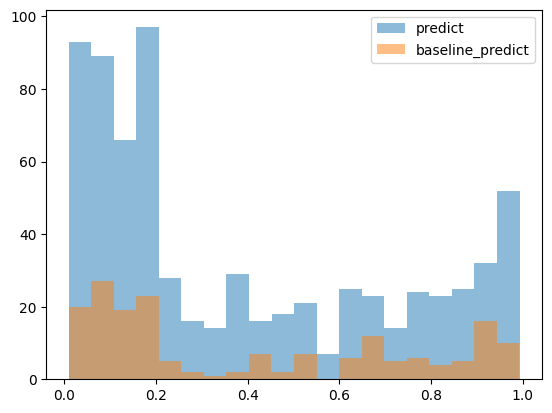

In [7]:
y_predict_proba = model.predict_proba(X)
y_baseline_predict_proba = model.predict_proba(X_baseline)

# 確率値をヒストグラムで表示
plt.hist(y_predict_proba[:, 1], bins=20, alpha=0.5, label="predict")
plt.hist(y_baseline_predict_proba[:, 1], bins=20, alpha=0.5, label="baseline_predict")
plt.legend()

### モデル推論

In [8]:
df_titanic_test = pd.read_csv("../data/test.csv")
df_titanic_test["Sex"] = le.fit_transform(df_titanic_test["Sex"])

X_test = df_titanic_test[["Sex","Fare"]]


id_test = df_titanic_test["PassengerId"]

In [9]:
y_test_pred = model.predict(X_test)
df_out = pd.DataFrame({"PassengerId": id_test, "Survived": y_test_pred})
display(df_out.head())
df_out.to_csv("../data/result/submission_baseline.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
